# function stores

In [1]:
def _classification_report(prediction , nameOfModel) : 
    #PREPARE SECCTION
    target_names = df_label["sleep"].unique().sort()
    clf_rbf_raw = classification_report(y_test,prediction ,target_names=target_names  ,output_dict=True)
    clf_rbf = pd.DataFrame(clf_rbf_raw)
    
    #PLOTING SECCTION
    fig = px.imshow(clf_rbf.iloc[:-1, :].T, text_auto=True ,aspect="auto",color_continuous_scale='GnBu'  )
    fig.update_layout(height=400, width=500, title_text='Classification Report of '+str(nameOfModel) +"SVM")
    fig.show()

# import lib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import  GridSearchCV ,RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

# (a) Load and Prepare Data

In [3]:
# Load data from csv 3 files
# acceleration.txt, heartrate.txt, labeled_sleep.txt
acceleration = "./Resources/46343_acceleration.txt"
heartrate = "./Resources/46343_heartrate.txt"
labeled_sleep="./Resources/46343_labeled_sleep.txt"
init_acc = pd.read_csv(acceleration, sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
init_heartrate = pd.read_csv(heartrate, sep = ',',names=['timedelta', 'heartrate'])
init_sleep = pd.read_csv(labeled_sleep, sep = ' ',names=['timedelta', 'sleep'])

acceleration2 = "./Resources/844359_acceleration.txt"
heartrate2 = "./Resources/844359_heartrate.txt"
labeled_sleep2="./Resources/844359_labeled_sleep.txt"
init_acc2 = pd.read_csv(acceleration2, sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
init_heartrate2 = pd.read_csv(heartrate2, sep = ',',names=['timedelta', 'heartrate'])
init_sleep2 = pd.read_csv(labeled_sleep2, sep = ' ',names=['timedelta', 'sleep'])

In [62]:
init_acc2.head()

,timedelta,accX,accY,accZ
0,-500.492604,-0.023804,-0.535217,-0.832169
1,-500.474720,-0.015472,-0.535690,-0.833450
2,-500.455065,-0.019379,-0.528381,-0.834518
3,-500.434675,-0.013473,-0.531311,-0.836334
4,-500.414981,-0.015366,-0.533752,-0.839294


In [63]:
init_heartrate2.head()

,timedelta,heartrate
0,-604720.29398,68
1,-604438.91905,64
2,-604032.54366,63
3,-603757.54405,64
4,-603454.66864,64


In [64]:
init_sleep2.head()

,timedelta,sleep
0,0,-1
1,30,-1
2,60,-1
3,90,-1
4,120,-1


In [65]:
acc_max_date = init_acc2["timedelta"].max()
acc_min_date = init_acc2["timedelta"].min()
print("acceleration start :" ,acc_min_date)
print("acceleration end :" ,acc_max_date)

acceleration start : -500.492604017
acceleration end : 28828.1484408


In [66]:
sleep_min = init_sleep2["timedelta"].min()
sleep_max = init_sleep2["timedelta"].max()
print("sleep label start :" ,sleep_min)
print("sleep label end :" ,sleep_max)

sleep label start : 0
sleep label end : 28440


In [67]:
hrate_min = init_heartrate2["timedelta"].min()
hrate_max = init_heartrate2["timedelta"].max()
print("heart rate start :" ,hrate_min)
print("heart rate end :" ,hrate_max)

heart rate start : -604720.29398
heart rate end : 28993.7883699


### select only intersected timedelta (ACC, HeartR, SleepL) (ช่วงเวลาที่มีข้อมูลใกล้กัน)

In [10]:
seleted_min  = 100
seleted_max = 5000

p2min = 7000
p2max = 12000

In [11]:
acc_new = init_acc[(init_acc['timedelta'] > seleted_min ) & (init_acc['timedelta'] <= seleted_max)]
heartRate_new = init_heartrate[(init_heartrate['timedelta'] >= seleted_min ) & (init_heartrate['timedelta'] < seleted_max)]
sleepLabel_new = init_sleep[(init_sleep['timedelta'] >= seleted_min ) &(init_sleep['timedelta'] <= seleted_max)]

In [12]:
p2_acc = init_acc[(init_acc2['timedelta'] > p2min ) & (init_acc2['timedelta'] <= p2max)]
p2_hr = init_heartrate[(init_heartrate2['timedelta'] >= p2min ) & (init_heartrate2['timedelta'] < p2max)]
p2_sleep = init_sleep[(init_sleep2['timedelta'] >= p2min ) &(init_sleep2['timedelta'] <= p2max)]

# Convert to datetime and round to second,

In [13]:
acc_new["timedelta"] = pd.DataFrame(pd.to_timedelta(acc_new['timedelta'], unit='s').round('s'))
p2_acc["timedelta"] = pd.DataFrame(pd.to_timedelta(p2_acc['timedelta'], unit='s').round('s'))

# Average rounding duplicated time

In [14]:
df_acc_X = acc_new.groupby('timedelta')['accX'].mean().reset_index()
df_acc_Y = acc_new.groupby('timedelta')['accY'].mean().reset_index()
df_acc_Z = acc_new.groupby('timedelta')['accZ'].mean().reset_index()

p2x = p2_acc.groupby('timedelta')['accX'].mean().reset_index()
p2y = p2_acc.groupby('timedelta')['accY'].mean().reset_index()
p2z = p2_acc.groupby('timedelta')['accZ'].mean().reset_index()

In [15]:
acc_df = df_acc_X.set_index('timedelta').join(df_acc_Y.set_index('timedelta')).join(df_acc_Z.set_index('timedelta'))
p2_acc_df = p2x.set_index('timedelta').join(p2y.set_index('timedelta')).join(p2z.set_index('timedelta'))

# (c) Load and Prepare Data (Heart rate)

In [16]:
heartRate_new["timedelta"] = pd.DataFrame(pd.to_timedelta(heartRate_new['timedelta'], unit='s').round('1s'))
p2_hr["timedelta"] = pd.DataFrame(pd.to_timedelta(p2_hr['timedelta'], unit='s').round('1s'))

In [17]:
# Group duplicate time
heartRate_new = heartRate_new.groupby('timedelta')['heartrate'].mean().reset_index()
p2_hr = p2_hr.groupby('timedelta')['heartrate'].mean().reset_index()

In [18]:
resample_rule = '1s'
heartrate_df = heartRate_new.set_index('timedelta').resample(resample_rule,).median().ffill()
p2_hr_df = p2_hr.set_index('timedelta').resample(resample_rule,).median().ffill()

# (c) Load and Prepare Data (Sleep Label)

In [19]:
sleepLabel_new["timedelta"] = pd.DataFrame(pd.to_timedelta(sleepLabel_new['timedelta'], unit='s').round('1s'))
p2_sleep["timedelta"] = pd.DataFrame(pd.to_timedelta(p2_sleep['timedelta'], unit='s').round('1s'))


In [20]:
sleeplabel_df = sleepLabel_new.set_index('timedelta').resample(resample_rule,).median().ffill()
p2_sleep_df = p2_sleep.set_index('timedelta').resample(resample_rule,).median().ffill()
p2_sleep_df

,sleep
timedelta,
0 days 01:57:00,2.0
0 days 01:57:01,2.0
0 days 01:57:02,2.0
0 days 01:57:03,2.0
0 days 01:57:04,2.0
...,...
0 days 03:19:56,1.0
0 days 03:19:57,1.0
0 days 03:19:58,1.0


# ( e) Merge Data and Standardized data

In [21]:
df2 = []
df2= pd.merge_asof(p2_acc_df, p2_hr_df, on='timedelta')
df2 = pd.merge_asof(df2, p2_sleep_df, on='timedelta')
df2

,timedelta,accX,accY,accZ,heartrate,sleep
0,0 days 01:30:34,0.469599,-0.147249,-0.871480,NaN,NaN
1,0 days 01:30:35,0.475812,-0.145139,-0.868174,NaN,NaN
2,0 days 01:30:36,0.472598,-0.146138,-0.870019,NaN,NaN
3,0 days 01:30:37,0.469959,-0.147274,-0.870844,NaN,NaN
4,0 days 01:30:38,0.469910,-0.147196,-0.870884,NaN,NaN
...,...,...,...,...,...,...
4988,0 days 02:53:42,-0.155810,-0.987706,-0.010401,79.0,5.0
4989,0 days 02:53:43,-0.156098,-0.987573,-0.010050,79.0,5.0
4990,0 days 02:53:44,-0.156004,-0.987456,-0.011153,79.0,5.0
4991,0 days 02:53:45,-0.155873,-0.987352,-0.011609,79.0,5.0


In [22]:
df = []
df = pd.merge_asof(acc_df, heartrate_df, on='timedelta')
df = pd.merge_asof(df, sleeplabel_df, on='timedelta')

In [23]:
df

,timedelta,accX,accY,accZ,heartrate,sleep
0,0 days 00:01:40,-0.376241,0.925141,-0.008848,83.0,NaN
1,0 days 00:01:41,-0.377814,0.925636,0.003382,83.0,NaN
2,0 days 00:01:42,-0.379298,0.924588,0.003643,83.0,NaN
3,0 days 00:01:43,-0.379019,0.925039,0.000995,83.0,NaN
4,0 days 00:01:44,-0.380270,0.924537,-0.000302,83.0,NaN
...,...,...,...,...,...,...
4896,0 days 01:23:16,0.475862,-0.153555,-0.866447,99.0,5.0
4897,0 days 01:23:17,0.482310,-0.151454,-0.863023,99.0,5.0
4898,0 days 01:23:18,0.484474,-0.150245,-0.861839,99.0,5.0
4899,0 days 01:23:19,0.477683,-0.152877,-0.865124,99.0,5.0


In [24]:
df.isnull().sum()

timedelta     0
accX          0
accY          0
accZ          0
heartrate     0
sleep        20
dtype: int64

# fill na sleep data wth 0

In [25]:
df['sleep'] = df["sleep"].fillna(value=0)
df['heartrate'] = df["heartrate"].fillna(df['heartrate'].median())

df2['sleep'] = df2["sleep"].fillna(value=0)
df2['heartrate'] = df2["heartrate"].fillna(df2['heartrate'].median())

# Standardized data

In [73]:
# Standardized data
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
df_feature = df[feature_columns]
df_label = df[label_columns]

df2_feature = df2[feature_columns]
df2_label = df2[label_columns]

In [74]:
std = StandardScaler()

In [75]:
norm_value = std.fit_transform(df_feature)
norm_p2 = std.fit_transform(df2_feature)

In [76]:
norm_df = pd.DataFrame(norm_value ,columns=feature_columns)
norm_df2 = pd.DataFrame(norm_p2 ,columns=feature_columns)

In [77]:
norm_df

,accX,accY,accZ,heartrate
0,-0.852123,4.752143,-0.864542,-0.576831
1,-0.858161,4.754342,-0.846914,-0.576831
2,-0.863857,4.749688,-0.846537,-0.576831
3,-0.862788,4.751690,-0.850354,-0.576831
4,-0.867589,4.749463,-0.852223,-0.576831
...,...,...,...,...
4896,2.419082,-0.035614,-2.100713,3.389565
4897,2.443837,-0.026287,-2.095778,3.389565
4898,2.452144,-0.020924,-2.094071,3.389565
4899,2.426073,-0.032603,-2.098807,3.389565


In [78]:
norm_df2

,accX,accY,accZ,heartrate
0,0.500399,-0.123978,-0.297783,0.177909
1,0.521290,-0.117301,-0.283547,0.177909
2,0.510482,-0.120461,-0.291491,0.177909
3,0.501610,-0.124056,-0.295047,0.177909
4,0.501445,-0.123810,-0.295218,0.177909
...,...,...,...,...
4988,-1.602572,-2.782816,3.409912,-0.904722
4989,-1.603542,-2.782393,3.411423,-0.904722
4990,-1.603226,-2.782025,3.406676,-0.904722
4991,-1.602786,-2.781694,3.404710,-0.904722


In [79]:
norm_df.describe()

,accX,accY,accZ,heartrate
count,4.901000e+03,4.901000e+03,4.901000e+03,4.901000e+03
mean,8.377982e-16,-1.861509e-16,-2.657649e-16,-1.950875e-15
std,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00
min,-2.704511e+00,-3.359624e+00,-2.264601e+00,-2.560029e+00
25%,-4.423339e-01,-3.070422e-01,4.360016e-01,-5.768310e-01
50%,-4.259448e-01,-1.544102e-01,4.986412e-01,-8.103150e-02
75%,-8.132738e-02,1.007925e-01,5.214851e-01,1.668682e-01
max,2.920783e+00,4.998028e+00,5.708197e-01,6.116462e+00


In [80]:
import plotly.express as px
from plotly.subplots import make_subplots
fig = make_subplots(rows=2, cols=1)
for i in range(len(feature_columns)) :
    fig.add_trace(
        go.Scatter(
            name=feature_columns[i],
            x=norm_df.index,
            y=norm_df[feature_columns[i]],
            showlegend=True),
         row=1, col=1
    )
fig.add_trace(
        go.Scatter(
            name="sleep",
            x=df_label.index,
            y=df_label["sleep"],
            showlegend=True),
     row=2, col=1)
fig.update_layout(height=900, width=1000, title_text="Visualization")

fig.show()

# MODEL PREPARATION

In [81]:
norm_df2.head()

,accX,accY,accZ,heartrate
0,0.500399,-0.123978,-0.297783,0.177909
1,0.521290,-0.117301,-0.283547,0.177909
2,0.510482,-0.120461,-0.291491,0.177909
3,0.501610,-0.124056,-0.295047,0.177909
4,0.501445,-0.123810,-0.295218,0.177909


In [82]:
Rseed = 40
x_train, x_test, y_train, y_test = train_test_split(norm_df, df_label, test_size = 0.33, random_state = Rseed)

In [83]:
x_train

,accX,accY,accZ,heartrate
3255,-0.439032,0.106491,0.522891,0.166868
46,-0.952809,4.700771,-0.771705,-0.328931
1858,-0.425199,-0.275487,0.499415,-0.576831
2099,-0.432755,-0.259785,0.500055,-0.328931
2421,-0.427972,-0.143114,0.509031,-0.081031
...,...,...,...,...
3603,-0.109086,-0.206471,0.533202,3.389565
4722,2.440643,-0.031927,-2.096196,-0.081031
3340,-0.438725,0.110862,0.521503,0.414768
3064,-0.440594,0.093788,0.522333,0.166868


In [84]:
c_val = 100 
gmm =0.1
d = 2

In [85]:
# Model initialize
svc_lin = SVC(kernel='linear', C=c_val)
svc_rbf = SVC(kernel='rbf', C=c_val, gamma=gmm)
svc_poly = SVC(kernel='poly', C=c_val, degree = d)

In [86]:
svc_lin.fit(x_train , y_train)
svc_rbf.fit(x_train , y_train)
svc_poly.fit(x_train , y_train)

SVC(C=100, degree=2, kernel='poly')

In [87]:
svc_rbf_pred = svc_rbf.predict(x_test)
linear_predict = svc_lin.predict(x_test)
poly_predict = svc_poly.predict(x_test)

# Visaulize Section

In [88]:
from sklearn.metrics import plot_confusion_matrix

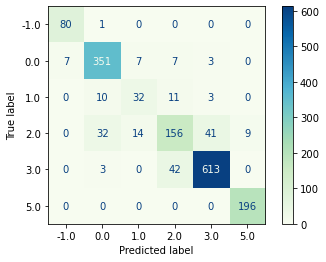

In [89]:
plot_confusion_matrix(svc_rbf, x_test, y_test ,cmap="GnBu")  
plt.show()
_classification_report(svc_rbf_pred ,"RBF" )

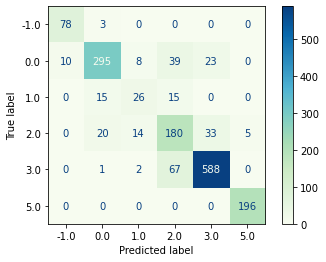

In [90]:
plot_confusion_matrix(svc_lin, x_test, y_test ,cmap="GnBu")  
plt.show()
_classification_report(linear_predict ,"Linear")

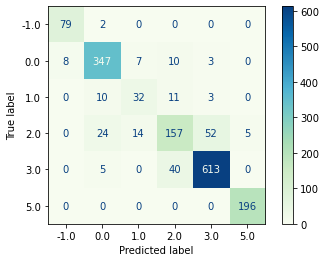

In [91]:
plot_confusion_matrix(svc_poly, x_test, y_test ,cmap="GnBu")  
plt.show()
_classification_report(poly_predict ,"Poly")

## Prepare Parameter Dictionary and Linear Regression() , SVR() with GridSearchCV() 


In [92]:
kernel = ['linear', 'rbf', 'poly']
C_list = [0.1, 1.0, 10.0, 100.0, 200.0, 500.0]
Gamma_list = [0.01, 0.1, 1.0]
degree = [2, 3]
params = dict( kernel = kernel, C = C_list, gamma = Gamma_list, degree = degree )

In [93]:
grid = GridSearchCV( estimator=SVC(), 
                    n_jobs = -1,
                    verbose = 10,
                    cv = 2,
                    scoring = "accuracy",
                   param_grid = params )

In [94]:
result = grid.fit(x_train , y_train)

Fitting 2 folds for each of 108 candidates, totalling 216 fits


In [95]:
BEST_PARAMS = result.best_estimator_
result.best_score_

0.9204964739571619

In [96]:
def _packed_rank(result):
    ranking = pd.DataFrame(result.cv_results_)[["params" ,"mean_test_score" ,"std_test_score","rank_test_score"]]
    ranking = ranking.sort_values(by=["rank_test_score"]).reset_index(drop=True)
    ranking = ranking.iloc[:25].reset_index()
    return ranking

def _barplotcompare(ranking_df):
    fig = px.bar(ranking_df ,x="mean_test_score", y="index" 
                 , text="mean_test_score" 
                 ,orientation="h" 
                 ,color="mean_test_score" ,range_x=[-.1,1] 
                 ,height=1000,
                )
  
    fig.add_trace(
        go.Scatter(
            name="Std",
            x=ranking_df.std_test_score,
            y=ranking_df.index,
            mode='lines+markers',
            line=go.scatter.Line(color="red"),
            text=ranking_df.std_test_score,
            showlegend=False,
        )
    )
    fig.show()

In [97]:
rankscore = _packed_rank(result)

In [107]:
_barplotcompare(rankscore)

In [108]:
BEST_PARAMS

SVC(C=500.0, degree=2, gamma=1.0)

In [109]:
BEST_PARAM = BEST_PARAMS.fit(x_train , y_train)

In [110]:
prediction_test=BEST_PARAM.predict(x_test)

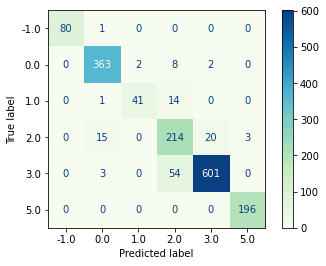

In [111]:
plot_confusion_matrix(grid, x_test, y_test ,cmap="GnBu")  
plt.show()
_classification_report(prediction_test ,"Poly")

# PLAY GROUND

# ลองเอา Model ไป predict คนอื่น

In [114]:
# Load data from csv 3 files
# acceleration.txt, heartrate.txt, labeled_sleep.txt
acceleration = "./Resources/46343_acceleration.txt"
heartrate = "./Resources/46343_heartrate.txt"
labeled_sleep="./Resources/46343_labeled_sleep.txt"
init_acc = pd.read_csv(acceleration, sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
init_heartrate = pd.read_csv(heartrate, sep = ',',names=['timedelta', 'heartrate'])
init_sleep = pd.read_csv(labeled_sleep, sep = ' ',names=['timedelta', 'sleep'])

In [119]:
x2 = norm_df2

In [120]:
y2_true = df2_label

In [121]:
prediction_p2=BEST_PARAM.predict(x2)

In [122]:
confusion_matrix(y2_true , prediction_p2)

array([[   0,    0,    0,    0,    0,    0],
       [   8,   10,    0,    0, 1598,    0],
       [ 176,   64,    0,    0,    0,    0],
       [ 358,   92,    0,    0,  240,    0],
       [   0,   42,    0,    0, 2238,    0],
       [ 167,    0,    0,    0,    0,    0]], dtype=int64)

In [123]:
clf = classification_report(y2_true ,prediction_p2)

In [124]:
print(clf)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.05      0.01      0.01      1616
         1.0       0.00      0.00      0.00       240
         2.0       0.00      0.00      0.00       690
         3.0       0.55      0.98      0.70      2280
         5.0       0.00      0.00      0.00       167

    accuracy                           0.45      4993
   macro avg       0.10      0.16      0.12      4993
weighted avg       0.27      0.45      0.33      4993



In [118]:
import plotly.express as px
from plotly.subplots import make_subplots
fig = make_subplots(rows=2, cols=2)
for i in range(len(feature_columns)) :
    fig.add_trace(
        go.Scatter(
            name=feature_columns[i],
            x=norm_df2.index,
            y=norm_df2[feature_columns[i]],
            showlegend=True),
         row=1, col=1
    )
fig.add_trace(
        go.Scatter(
            name=feature_columns[i],
            x=norm_df.index,
            y=norm_df[feature_columns[i]],
            showlegend=True),
         row=1, col=2
)

fig.add_trace(
        go.Scatter(
            name="sleep",
            x=y2_true.index,
            y=y2_true["sleep"],
            showlegend=True),
     row=2, col=1)
fig.update_layout(height=900, width=1000, title_text="Visualization")

fig.show()